# **Model Testing**

In [154]:
import pandas as pd 
import pickle
import os

import pandas as pd # pandas is ised to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors # 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale # scale and center data
from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # draw confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA # perform PCA to plot the data


import pickle  
import joblib 


# import matlab data
from scipy.io import loadmat

### *Function*

In [155]:
def callmodel(modeldict, modeltype, subtype, subject):
    return modeldict[f'clf_{modeltype}_{subtype}_sub{str(subject)}']

In [156]:
def load_subject_data(subject_number):
    # [INPUT: EEG & ECG data] load the .mat file
    data_path = f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject_number}.mat'
    data = loadmat(data_path)
    ECG_features = data['ECG_features']
    EEG_features = data['EEG_features']
    channelList_pre = data['channelList'][0]
    channelList = []
    for i in range(len(channelList_pre)):
        channelList.append(channelList_pre[i][0])
    
    # [OUTPUT: ORD] load the .xlsx file
    ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'
    xl = pd.ExcelFile(ord_filepath)
    sheet_name = xl.sheet_names[subject_number-1] # access the subject's sheet by index
    ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)
    
    return ECG_features, EEG_features, ord_60min, channelList

In [157]:
def ECG_dataframe(subject, ECG_features_allcases):
    ECG_features_py = []
    
    # Loop through each struct in the struct array
    for i in range(ECG_features_allcases[subject].shape[0]):  # Adjusted loop for Nx1 struct array
        struct = ECG_features_allcases[subject][i, 0]
        scalar_dict = {
            'Index': struct['Index'][0, 0],
            'VLF': struct['VLF'][0, 0],
            'LF': struct['LF'][0, 0],
            'HF': struct['HF'][0, 0],
            'LFHF': struct['LFHF'][0, 0],
            'pLF': struct['pLF'][0, 0],
            'pHF': struct['pHF'][0, 0]
        }
        ECG_features_py.append(scalar_dict)

    # Convert scalar values to DataFrame
    ECG_features_df = pd.DataFrame(ECG_features_py)
    
    return ECG_features_df

In [158]:
def EEG_dataframe_list(subject, EEG_features_allcases):
    
    EEG_features_df_list = []

    numEEGchannels = EEG_features_allcases[subject].shape[1]
    numEEGepochs = EEG_features_allcases[subject].shape[0]
    EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

    # Assuming struct_array is of shape (139, 12), iterate through each struct
    for channel in range(numEEGchannels):  # for j in range(12)
        channelfeatures = []
        for epoch in range(numEEGepochs):  # for i in range(139)
            epochfeatures = {field: EEG_features_allcases[subject][epoch, channel][field][0,0] for field in EEG_featurelist}
            channelfeatures.append(epochfeatures)
        
        channelfeatures_df = pd.DataFrame(channelfeatures)
        EEG_features_df_list.append(channelfeatures_df)
        
    return EEG_features_df_list

In [159]:
def ord_dataframe(subject, ord_60min_allcases):
    
    # 1) ord_60min -> ord_epoch
    ord_epoch = []

    for i in range(len(ord_60min_allcases[subject]) - 1):
        # Append the current ORD value
        ord_epoch.append(ord_60min_allcases[subject].iloc[i, 3])
        
        # Calculate and append the mean of the current and next ORD values
        mean_ord = np.mean([ord_60min_allcases[subject].iloc[i, 3], ord_60min_allcases[subject].iloc[i + 1, 3]])
        ord_epoch.append(mean_ord)

    # Append the last ORD value since it won't have a subsequent value to average with
    ord_epoch.append(ord_60min_allcases[subject].iloc[-1, 3])

    # Convert the list to a DataFrame and set the column title as 'ord score'
    ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

    #######################################

    # 2) Simplify to 3 classes
    ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))

    # Mapping from 'ORD class' to 'class name'
    class_name_mapping = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }

    # Add 'class name' column by mapping 'ORD class' to names
    ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

    return ord_epoch
    

In [160]:
def combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch):
    # EEG_features_df (df 139x7): row 10-128, column 1-6
    # ECG_features_df (df 139x7): row 10-128, column 1-6
    # ord_epoch (df 119x3): all row, column 1-2

    # 1) Select the specified rows and columns from each DataFrame
    # EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    EEG_features_selected = EEG_features_df.loc[10:129, ~EEG_features_df.columns.str.startswith('Epoch')]
    ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
    Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
    ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

    # 2) Combine these features into a new DataFrame
    # Concatenate EEG and ECG features along the columns
    combined_data = pd.concat([
                                Epoch_minute.reset_index(drop=True),
                                EEG_features_selected.reset_index(drop=True), 
                                ECG_features_selected.reset_index(drop=True),
                                ord_epoch_selected.reset_index(drop=True)], axis=1)
    # combined_data = combined_data.dropna()

    # Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
    return combined_data

In [161]:
def result_summary(model, X, X_scaled, y):
    # Predict labels on the training data
    y_pred = model.predict(X_scaled)
    original_index = X.index.to_numpy()

    # Create DataFrame with columns
    result_summary = pd.DataFrame({
        "Original Index": original_index,
        "Original Label": y,  # Original labels
        "Predicted Label": y_pred,  # Predicted labels
        "True/False": y_pred == y  # True/False indicator (correctness)
    })

    result_summary = result_summary.sort_values(by="Original Index")
    return result_summary

In [162]:
def classwise_accuracy(model, X_test_scaled, y_test):
    # Predict the labels for the test set
    y_pred = model.predict(X_test_scaled)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    # Define class names mapping
    class_names = {
        1: 'Alert',
        2: 'Moderately Drowsy',
        3: 'Extremely Drowsy'
    }
    
    # Print accuracy for each class
    for i, accuracy in enumerate(class_accuracies, start=1):
        class_name = class_names.get(i, f"Class {i}")
        print(f"Accuracy of {class_name}: {accuracy * 100:.4f}%")

    # Separator
    print("-" * 40)
    
    # Calculate and print F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro') # Aggregates the contributions of all classes to compute the average F1 score. Focuses on overall performance.
    weighted_f1 = f1_score(y_test, y_pred, average='weighted') # Computes the F1 score for each class, but uses the number of true instances for each class as weight.
    macro_f1 = f1_score(y_test, y_pred, average='macro') # Computes the F1 score separately for each class and then takes the average. Treats all classes equally.
    
    print(f"Micro-average F1: {micro_f1 * 100:.4f}%") 
    print(f"Weighted-average F1: {weighted_f1 * 100:.4f}%")    
    print(f"Macro-average F1: {macro_f1 * 100:.4f}%")

    # Package the metrics into a dictionary
    metrics = {
        'class_accuracies': class_accuracies,
        'micro_f1': micro_f1,
        'weighted_f1': weighted_f1,
        'macro_f1': macro_f1,
    }

    return metrics

In [163]:
def accuracy_record(dataframe, model, subject_train, subject_test, EEG_channel_train, X, X_test_scaled, y_test):
    # Assuming classwise_accuracy is defined elsewhere and returns a dictionary with the metrics
    metrics = classwise_accuracy(model, X_test_scaled, y_test)

    if isinstance(X, str) and X == 'pca':
        input_features = 'PCA'
    else:
        input_features = ', '.join(X.columns)

    # Prepare the record to be appended
    record = {
        # 'model': type(model).__name__,  # Get the class name of the model
        'model': str(model),
        'subject_train': subject_train,
        'subject_test': subject_test,
        'channel' : EEG_channel_train,
        'input_features': input_features,  # Column names as a string
        'num_features': model.n_features_in_,
        'class1_accuracy': metrics['class_accuracies'][0] if len(metrics['class_accuracies']) > 0 else None,
        'class2_accuracy': metrics['class_accuracies'][1] if len(metrics['class_accuracies']) > 1 else None,
        'class3_accuracy': metrics['class_accuracies'][2] if len(metrics['class_accuracies']) > 2 else None,
        'micro_f1': metrics['micro_f1'],
        'weighted_f1': metrics['weighted_f1'],
        'macro_f1': metrics['macro_f1'],
    }

    # Append the record to the DataFrame
    record_df = pd.DataFrame.from_records([record])
    dataframe = pd.concat([dataframe, record_df], ignore_index=True)
    
    return dataframe


In [164]:
accuracy_newcase = pd.DataFrame()

### *Import Model*

In [165]:
subject_train_list = []

while True:
    subject = input('Import the model trained by data from subject: ')
    if subject == '':
        break  # Exit the loop if no input is provided and just Enter is pressed.
    else:
        try:
            # Convert the input to an integer and add it to the list
            subject_number = int(subject)
            subject_train_list.append(subject_number)
        except ValueError:
            # Handle the case where the input is not an integer
            print("Please enter a valid number or press Enter to finish.")

print("Subjects entered:", subject_train_list)


Subjects entered: [1, 3, 7]


In [166]:
subject_train = ''.join(str(x) for x in subject_train_list)
print('Training data: Subject', str(subject_train))

Training data: Subject 137


In [167]:
subjectx = f"subject{subject_train}"

# Define the folder path containing the models
model_folder = "C:\\Users\\Natchira\\Documents\\M.Eng Thesis\\Model"

# Create an empty dictionary to store the loaded models
models = {}

# Loop through all files in the folder
for filename in os.listdir(model_folder):

    # Check if the filename starts with the specified subject
    if filename.startswith(subjectx + "_"):
        # Extract model type, process, and subject number from the filename
        parts = filename.split("_")
        modeltype = parts[1]  # Convert model type to lowercase (dt, knn, rf, svm)
        modeltype_map = {
            "DecisionTree": "dt",
            "KNearestNeighbors": "knn",
            "RandomForest": "rf",
            "SupportVectorMachine": "svm",
        }
        modeltype = modeltype_map.get(modeltype, modeltype)
        process = parts[2].split(".")[0]  # Extract process part before extension

        # Load the model
        with open(os.path.join(model_folder, filename), "rb") as f:
            model = pickle.load(f)

        var_name = f"clf_{modeltype}_{process}_sub{subject_train}"

        # Store the model in the dictionary with the constructed variable name
        models[var_name] = model


In [168]:
# ALL MODELS
print("Loaded models:")
for name, model in models.items():
    print(f"{name}: {model}")

Loaded models:
clf_pca_scaler_sub137: StandardScaler()
clf_pca_transformer_sub137: PCA()
clf_smote_scaler_sub137: StandardScaler()
clf_standard_scaler_sub137: StandardScaler()
clf_svm_cv_sub137: SVC(C=10, class_weight='balanced', gamma=0.1, random_state=7)
clf_svm_pca_sub137: SVC(C=10, class_weight='balanced', random_state=7)
clf_svm_prelim_sub137: SVC(class_weight='balanced', random_state=7)
clf_svm_smote_sub137: SVC(C=10, class_weight='balanced', random_state=7)


In [169]:
callmodel(models, 'svm', 'cv', int(subject_train))

SVC(C=10, class_weight='balanced', gamma=0.1, random_state=7)

### *Import Testing Data*

In [235]:
subject_test = str(input('Testing data from subject: '))
print('Testing data: Subject', str(subject_test))

Testing data: Subject 4


In [236]:
EEG_features_allcases = []
ECG_features_allcases = []
ord_60min_allcases = []

ECG_features, EEG_features, ord_60min = load_subject_data(int(subject_test))
EEG_features_allcases.append(EEG_features)
ECG_features_allcases.append(ECG_features)
ord_60min_allcases.append(ord_60min)



In [237]:
ECG_field_names = ECG_features.dtype.names
EEG_field_names = EEG_features.dtype.names
print('Loaded Data')
print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

Loaded Data
ECG Features:  ('Index', 'ECG', 'ECGTimestamps', 'RRI', 'RRITimestamps', 'VLF', 'LF', 'HF', 'LFHF', 'RPeakTimestamps', 'pLF', 'pHF')
EEG Features:  ('Epoch', 'TotalPower', 'AlphaPower', 'AlphaRelative', 'ThetaPower', 'ThetaRelative', 'BetaPower1', 'BetaPower2', 'RBR', 'BetaPower', 'BetaRelative', 'DeltaPower', 'DeltaRelative', 'AlphaBetaRatio', 'TA_BRatio')


In [239]:
EEG_channel_list = []

while True:
    channel = input('training channel: ')
    if channel == '':
        break  # Exit the loop if no input is provided and just Enter is pressed.
    else:
        try:
            # Convert the input to an integer and add it to the list
            channel_number = int(channel)
            EEG_channel_list.append(channel_number)
        except ValueError:
            # Handle the case where the input is not an integer
            print("Please enter a valid number or press Enter to finish.")

print("Channels entered:", EEG_channel_list)

EEG_channel_train = ''.join(str(x) for x in EEG_channel_list)
print(EEG_channel_train)


Channels entered: [2, 3]
23


In [240]:
initial_kss = [7, 6, 5, 5, 5, 5, 5, 7, 6, 4, 5, 6, 7, 6, 5]

In [241]:
ECG_features_df = ECG_dataframe(0, ECG_features_allcases) # ECG_features_df
    
EEG_features_df_list = EEG_dataframe_list(0, EEG_features_allcases) # EEG_features_df_list
    # EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1
EEG_features_df = pd.DataFrame()

for EEG_channel in EEG_channel_list:
    EEG_features_append = EEG_features_df_list[EEG_channel-1].copy() # Features from Channel 1
    EEG_features_append.columns = [f'{col}_{EEG_channel}' for col in EEG_features_append.columns]
    EEG_features_df = pd.concat([EEG_features_df, EEG_features_append], axis=1)
    
ord_epoch = ord_dataframe(0, ord_60min_allcases)
    
print(ord_epoch['class name'].value_counts())

combined_data = combined_dataframe(EEG_features_df, ECG_features_df, ord_epoch)
combined_data.insert(1, 'Initial_KSS', initial_kss[int(subject_test)-1])


combined_data = combined_data.dropna()

display(combined_data)

class name
Alert                70
Moderately Drowsy    43
Name: count, dtype: int64


,Epoch_minute,Initial_KSS,DeltaRelative_2,ThetaRelative_2,AlphaRelative_2,BetaRelative_2,AlphaBetaRatio_2,TA_BRatio_2,DeltaRelative_3,ThetaRelative_3,...,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,5,0.567177,0.095951,0.085368,0.204514,0.417417,0.886583,0.833605,0.074425,...,0.519331,1.923867,0.359259,1.124906,0.299253,3.759046,78.987383,21.012617,1.0,Alert
1,1.5,5,0.654357,0.113444,0.092311,0.134759,0.685009,1.526836,0.863311,0.070495,...,0.601046,2.360482,0.240259,1.015652,0.693581,1.464360,59.421511,40.578489,1.0,Alert
2,2.0,5,0.780174,0.082595,0.054006,0.079340,0.680694,1.721724,0.876702,0.060915,...,0.614780,2.253112,0.206305,1.626968,0.194992,8.343768,89.297680,10.702320,1.0,Alert
3,2.5,5,0.813604,0.068983,0.045285,0.068364,0.662421,1.671485,0.872655,0.058845,...,0.559486,1.957520,0.805125,0.965543,0.277513,3.479275,77.674957,22.325043,1.0,Alert
4,3.0,5,0.799101,0.073999,0.054617,0.070287,0.777060,1.829883,0.866893,0.061288,...,0.533411,1.922785,1.203465,0.578481,0.345543,1.674123,62.604561,37.395439,1.0,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,58.0,5,0.441903,0.199968,0.172347,0.179492,0.960190,2.074266,0.793468,0.126336,...,0.768294,3.508488,0.450684,1.408985,0.239453,5.884180,85.473942,14.526058,2.0,Moderately Drowsy
115,58.5,5,0.402549,0.200285,0.197685,0.192954,1.024521,2.062518,0.721540,0.164696,...,0.827744,3.424002,0.796061,1.132435,0.224680,5.040209,83.444282,16.555718,2.0,Moderately Drowsy
116,59.0,5,0.500184,0.187818,0.123335,0.179824,0.685862,1.730316,0.682454,0.154615,...,0.686890,2.321619,1.343825,0.722642,0.078389,9.218609,90.213932,9.786068,2.0,Moderately Drowsy
117,59.5,5,0.615225,0.152479,0.101859,0.127698,0.797654,1.991719,0.694895,0.159651,...,0.781288,2.778206,1.564389,0.403778,0.161839,2.494942,71.387226,28.612774,2.0,Moderately Drowsy


##### 2.1 Load the .mat file (input) and .csv file (output)

In [242]:
# subject = int(subject_test)

# # [INPUT: EEG & ECG data] load the .mat file

# data = loadmat(f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/EEG_ECG_Features/EEG_ECG_Features_subject{subject}.mat')
# ECG_features = data['ECG_features']
# EEG_features = data['EEG_features']

# # [OUTPUT: ORD] load the .csv file
# # ord_60min = pd.read_csv(f'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels_subject{subject}.csv')
# ord_filepath = 'C:/Users/Natchira/Documents/M.eng (from hp)/Thesis/OpenViBE/ORD_labels.xlsx'

# xl = pd.ExcelFile(ord_filepath)
# sheet_name = xl.sheet_names[subject-1] # access the subject's sheet

# ord_60min = pd.read_excel(ord_filepath, sheet_name=sheet_name)

In [243]:
# ECG_field_names = ECG_features.dtype.names
# EEG_field_names = EEG_features.dtype.names
# print('Loaded Data')
# print('ECG Features: ', ECG_field_names) # data stored in 'ECG_features'
# print('EEG Features: ', EEG_field_names) # data stored in 'EEG_features'

##### **2.2 [ECG] Create dataframe of selected ECG features** (ECG_features_df)

- *ECG_features_df*: (Index, VLF, LF, HF, LFHF, pLF, pHF)
- ecg_data
- ecg_timestamps_data
- rri_data
- rri_timestamps_data
- rpeak_timestamps_data

In [178]:
# ECG_features_py = []

# # Optional: Initialize lists or dicts to hold array data
# ecg_data = []
# ecg_timestamps_data = []
# rri_data = []
# rri_timestamps_data = []
# rpeak_timestamps_data = []

# # Loop through each struct in the struct array
# for i in range(ECG_features.shape[0]):  # Adjusted loop for Nx1 struct array
#     struct = ECG_features[i, 0]
#     scalar_dict = {
#         'Index': struct['Index'][0, 0],
#         'VLF': struct['VLF'][0, 0],
#         'LF': struct['LF'][0, 0],
#         'HF': struct['HF'][0, 0],
#         'LFHF': struct['LFHF'][0, 0],
#         'pLF': struct['pLF'][0, 0],
#         'pHF': struct['pHF'][0, 0]
#     }
#     ECG_features_py.append(scalar_dict)

#     # Handle arrays separately
#     ecg_data.append(struct['ECG'][0])  # Flatten if needed
#     ecg_timestamps_data.append(struct['ECGTimestamps'][0])
#     rri_data.append(struct['RRI'][0])
#     rri_timestamps_data.append(struct['RRITimestamps'][0])
#     rpeak_timestamps_data.append(struct['RPeakTimestamps'][0])

# # Convert scalar values to DataFrame
# ECG_features_df = pd.DataFrame(ECG_features_py)

##### **2.3 [EEG] Create dataframe of selected EEG features** (EEG_features_df)


- *EEG_features_df_list*: List of 12 dataframes, containing selected EEG features from 12 EEG channels

In [146]:
# EEG_features_df_list = []

# numEEGchannels = EEG_features.shape[1]
# numEEGepochs = EEG_features.shape[0]
# EEG_featurelist = ['Epoch', 'DeltaRelative', 'ThetaRelative', 'AlphaRelative', 'BetaRelative', 'AlphaBetaRatio', 'TA_BRatio']

# # Assuming struct_array is of shape (139, 12), iterate through each struct
# for channel in range(numEEGchannels):  # for j in range(12)
#     channelfeatures = []
#     for epoch in range(numEEGepochs):  # for i in range(139)
#         epochfeatures = {field: EEG_features[epoch, channel][field][0,0] for field in EEG_featurelist}
#         channelfeatures.append(epochfeatures)
    
#     channelfeatures_df = pd.DataFrame(channelfeatures)
#     EEG_features_df_list.append(channelfeatures_df)

In [147]:
# EEG_features_df_list[1].head() # Features from Channel 2

- *EEG_features_df*: The dataframe of selected EEG features (*Epoch, DeltaRelative, ThetaRelative, AlphaRelative, BetaRelative, AlphaBetaRatio, TA_BRatio*)

In [148]:
# EEG_channel = int(input('EEG Channel: '))
# EEG_features_df = EEG_features_df_list[EEG_channel-1] # Features from Channel 1

##### **2.4 [ORD] Create dataframe of ORD labels for each epoch** (ORD_epoch)


**1) Converting *ord_60min* to *ord_epoch***
- ***ord_60min***: ORD labels for each minute
- ***ord_epoch***: ORD labels for each epoch (1-minute length with 50% overlap)

In [29]:
# display(ord_60min.head())
# print(len(ord_60min))

In [30]:
# ord_epoch = []

# for i in range(len(ord_60min) - 1):
#     # Append the current ORD value
#     ord_epoch.append(ord_60min.iloc[i, 3])
    
#     # Calculate and append the mean of the current and next ORD values
#     mean_ord = np.mean([ord_60min.iloc[i, 3], ord_60min.iloc[i + 1, 3]])
#     ord_epoch.append(mean_ord)

# # Append the last ORD value since it won't have a subsequent value to average with
# ord_epoch.append(ord_60min.iloc[-1, 3])

# # Convert the list to a DataFrame and set the column title as 'ord score'
# ord_epoch = pd.DataFrame(ord_epoch, columns=['ORD score'])

# ord_epoch


**2) Simplify ORD labels to 3 classes**


'ORD class' is assigned for each epoch based on this criteria
- *Alert*: ORD score <= 2 
- *Moderately Drowsy*: 2 < ORD score <= 3
- *Extremely Drowsy*: ORD score > 3

In [31]:
# # Add 'ORD class' column based on 'ord score' values
# ord_epoch['ORD class'] = ord_epoch['ORD score'].apply(lambda x: np.nan if np.isnan(x) else (1 if x <= 2 else (2 if x <= 3 else 3)))

# # Mapping from 'ORD class' to 'class name'
# class_name_mapping = {
#     1: 'Alert',
#     2: 'Moderately Drowsy',
#     3: 'Extremely Drowsy'
# }

# # Add 'class name' column by mapping 'ORD class' to names
# ord_epoch['class name'] = ord_epoch['ORD class'].map(class_name_mapping)

# print(ord_epoch)

In [32]:
# # Count the epochs of each 'ORD class'
# class_counts = ord_epoch['class name'].value_counts()
# print(class_counts)

##### **2.5 Create dataframe of EEG features, ECG features, ORD labels for each epoch** (combined_data)

sync data from each dataframe, including only epochs in the 60-minute driving phase

In [33]:
# # EEG_features_df (df 139x7): row 10-128, column 1-6
# # ECG_features_df (df 139x7): row 10-128, column 1-6
# # ord_epoch (df 119x3): all row, column 1-2

# # 1) Select the specified rows and columns from each DataFrame
# EEG_features_selected = EEG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
# ECG_features_selected = ECG_features_df.iloc[10:129, 1:7]  # Rows 10-128, Columns 1-6
# Epoch_minute = pd.DataFrame({'Epoch_minute': np.linspace(1, 1 + 0.5 * (119 - 1), 119)})
# ord_epoch_selected = ord_epoch.iloc[:, 1:3]  # Columns 1-2

# # 2) Combine these features into a new DataFrame
# # Concatenate EEG and ECG features along the columns
# combined_data = pd.concat([Epoch_minute.reset_index(drop=True),
#                                EEG_features_selected.reset_index(drop=True), 
#                                ECG_features_selected.reset_index(drop=True),
#                                ord_epoch_selected.reset_index(drop=True)], axis=1)
# combined_data = combined_data.dropna()

# # Now combined_data contains your inputs (EEG and ECG features) and outputs (ORD class and class name)
# print(combined_data.shape)
# combined_data

### *Data Preparation*

In [244]:
combined_data.head()

,Epoch_minute,Initial_KSS,DeltaRelative_2,ThetaRelative_2,AlphaRelative_2,BetaRelative_2,AlphaBetaRatio_2,TA_BRatio_2,DeltaRelative_3,ThetaRelative_3,...,AlphaBetaRatio_3,TA_BRatio_3,VLF,LF,HF,LFHF,pLF,pHF,ORD class,class name
0,1.0,5,0.567177,0.095951,0.085368,0.204514,0.417417,0.886583,0.833605,0.074425,...,0.519331,1.923867,0.359259,1.124906,0.299253,3.759046,78.987383,21.012617,1.0,Alert
1,1.5,5,0.654357,0.113444,0.092311,0.134759,0.685009,1.526836,0.863311,0.070495,...,0.601046,2.360482,0.240259,1.015652,0.693581,1.464360,59.421511,40.578489,1.0,Alert
2,2.0,5,0.780174,0.082595,0.054006,0.079340,0.680694,1.721724,0.876702,0.060915,...,0.614780,2.253112,0.206305,1.626968,0.194992,8.343768,89.297680,10.702320,1.0,Alert
3,2.5,5,0.813604,0.068983,0.045285,0.068364,0.662421,1.671485,0.872655,0.058845,...,0.559486,1.957520,0.805125,0.965543,0.277513,3.479275,77.674957,22.325043,1.0,Alert
4,3.0,5,0.799101,0.073999,0.054617,0.070287,0.777060,1.829883,0.866893,0.061288,...,0.533411,1.922785,1.203465,0.578481,0.345543,1.674123,62.604561,37.395439,1.0,Alert


In [245]:
# INPUT: Epoch_minute + EEG features + ECG features
# X = combined_data.iloc[:, 0:13].copy()
# X = combined_data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]].copy()

excluded_columns = ['VLF', 'LF', 'HF', 'ORD class', 'class name']
X = combined_data.loc[:, ~combined_data.columns.isin(excluded_columns)].copy()

print(X.shape)
X.head()

(113, 17)


,Epoch_minute,Initial_KSS,DeltaRelative_2,ThetaRelative_2,AlphaRelative_2,BetaRelative_2,AlphaBetaRatio_2,TA_BRatio_2,DeltaRelative_3,ThetaRelative_3,AlphaRelative_3,BetaRelative_3,AlphaBetaRatio_3,TA_BRatio_3,LFHF,pLF,pHF
0,1.0,5,0.567177,0.095951,0.085368,0.204514,0.417417,0.886583,0.833605,0.074425,0.027519,0.052989,0.519331,1.923867,3.759046,78.987383,21.012617
1,1.5,5,0.654357,0.113444,0.092311,0.134759,0.685009,1.526836,0.863311,0.070495,0.024082,0.040067,0.601046,2.360482,1.464360,59.421511,40.578489
2,2.0,5,0.780174,0.082595,0.054006,0.079340,0.680694,1.721724,0.876702,0.060915,0.022858,0.037181,0.614780,2.253112,8.343768,89.297680,10.702320
3,2.5,5,0.813604,0.068983,0.045285,0.068364,0.662421,1.671485,0.872655,0.058845,0.023549,0.042091,0.559486,1.957520,3.479275,77.674957,22.325043
4,3.0,5,0.799101,0.073999,0.054617,0.070287,0.777060,1.829883,0.866893,0.061288,0.023530,0.044112,0.533411,1.922785,1.674123,62.604561,37.395439


In [246]:
# OUTPUT: ORD class
y = combined_data['ORD class'].copy()
print(y.shape)
y.head()

(113,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: ORD class, dtype: float64

In [247]:
class_counts = y.value_counts()
print(class_counts)

ORD class
1.0    70
2.0    43
Name: count, dtype: int64


In [248]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject_train}_standard_scaler.pkl', "rb") as f:
    scaler = pickle.load(f)

In [249]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject_train}_smote_scaler.pkl', "rb") as f:
    smote_scaler = pickle.load(f)

In [250]:
# scaler = StandardScaler()

# X_scaled = scaler.fit_transform(X)
X_scaled = scaler.transform(X)
X_smote_scaled = smote_scaler.transform(X)

### *Model Testing*

##### **1. SVM**

In [251]:
clf_svm = callmodel(models, 'svm', 'cv', int(subject_train))

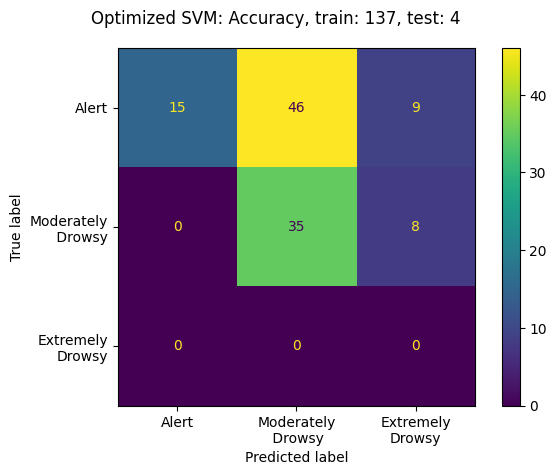

In [252]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm, 
                      X_scaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized SVM: Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [253]:
# Training Accuracy
classwise_accuracy(clf_svm, X_scaled, y)

Accuracy of Alert: 21.4286%
Accuracy of Moderately Drowsy: 81.3953%
Accuracy of Extremely Drowsy: nan%
----------------------------------------
Micro-average F1: 44.2478%
Weighted-average F1: 43.3452%
Macro-average F1: 30.5819%


C:\Users\Natchira\AppData\Local\Temp\ipykernel_23144\3378109123.py:9: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


{'class_accuracies': array([0.21428571, 0.81395349,        nan]),
 'micro_f1': 0.4424778761061947,
 'weighted_f1': 0.43345199912679894,
 'macro_f1': 0.3058191018342821}

In [254]:
accuracy_newcase = accuracy_record(accuracy_newcase, clf_svm, subject_train, subject_test, EEG_channel_train, X, X_scaled, y)
display(accuracy_newcase)

Accuracy of Alert: 21.4286%
Accuracy of Moderately Drowsy: 81.3953%
Accuracy of Extremely Drowsy: nan%
----------------------------------------
Micro-average F1: 44.2478%
Weighted-average F1: 43.3452%
Macro-average F1: 30.5819%


C:\Users\Natchira\AppData\Local\Temp\ipykernel_23144\3378109123.py:9: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,2,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.833333,0.586207,0.652174,0.720000,0.726424,0.690042
1,"SVC(C=10, class_weight='balanced', random_stat...",137,2,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.791667,0.344828,0.869565,0.680000,0.673821,0.640512
2,"SVC(C=10, class_weight='balanced', random_stat...",137,2,23,PCA,6,0.520833,0.517241,0.782609,0.580000,0.595674,0.580679
3,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,5,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.090909,1.000000,NaN,0.150943,0.164999,0.102694
4,"SVC(C=10, class_weight='balanced', random_stat...",137,5,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.141414,0.857143,NaN,0.188679,0.240229,0.127040
5,"SVC(C=10, class_weight='balanced', random_stat...",137,5,23,PCA,6,0.101010,0.714286,NaN,0.141509,0.178108,0.095176
6,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,4,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.214286,0.813953,NaN,0.442478,0.433452,0.305819


In [255]:
summary = result_summary(clf_svm, X, X_scaled, y)

#################

In [256]:
clf_svm_smote = callmodel(models, 'svm', 'smote', int(subject_train))

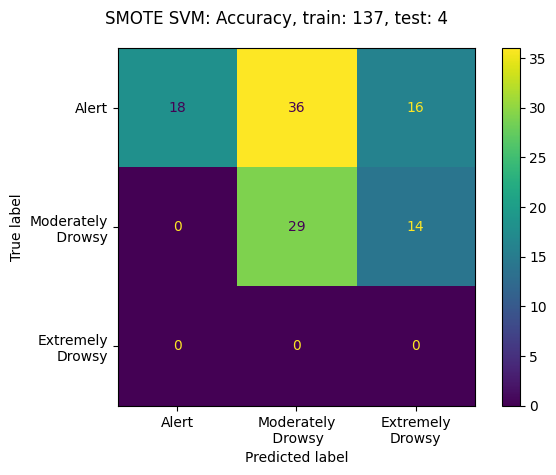

In [257]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_smote, 
                      X_smote_scaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("SMOTE SVM: Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [258]:
# Training Accuracy
classwise_accuracy(clf_svm_smote, X_smote_scaled, y)

Accuracy of Alert: 25.7143%
Accuracy of Moderately Drowsy: 67.4419%
Accuracy of Extremely Drowsy: nan%
----------------------------------------
Micro-average F1: 41.5929%
Weighted-average F1: 45.7778%
Macro-average F1: 31.5376%


C:\Users\Natchira\AppData\Local\Temp\ipykernel_23144\3378109123.py:9: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


{'class_accuracies': array([0.25714286, 0.6744186 ,        nan]),
 'micro_f1': 0.415929203539823,
 'weighted_f1': 0.4577783737075773,
 'macro_f1': 0.3153759820426487}

In [259]:
accuracy_newcase = accuracy_record(accuracy_newcase, clf_svm_smote, subject_train, subject_test, EEG_channel_train, X, X_smote_scaled, y)
display(accuracy_newcase)

Accuracy of Alert: 25.7143%
Accuracy of Moderately Drowsy: 67.4419%
Accuracy of Extremely Drowsy: nan%
----------------------------------------
Micro-average F1: 41.5929%
Weighted-average F1: 45.7778%
Macro-average F1: 31.5376%


C:\Users\Natchira\AppData\Local\Temp\ipykernel_23144\3378109123.py:9: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,2,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.833333,0.586207,0.652174,0.720000,0.726424,0.690042
1,"SVC(C=10, class_weight='balanced', random_stat...",137,2,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.791667,0.344828,0.869565,0.680000,0.673821,0.640512
2,"SVC(C=10, class_weight='balanced', random_stat...",137,2,23,PCA,6,0.520833,0.517241,0.782609,0.580000,0.595674,0.580679
3,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,5,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.090909,1.000000,NaN,0.150943,0.164999,0.102694
4,"SVC(C=10, class_weight='balanced', random_stat...",137,5,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.141414,0.857143,NaN,0.188679,0.240229,0.127040
5,"SVC(C=10, class_weight='balanced', random_stat...",137,5,23,PCA,6,0.101010,0.714286,NaN,0.141509,0.178108,0.095176
6,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,4,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.214286,0.813953,NaN,0.442478,0.433452,0.305819
7,"SVC(C=10, class_weight='balanced', random_stat...",137,4,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.257143,0.674419,NaN,0.415929,0.457778,0.315376


In [260]:
summary = result_summary(clf_svm_smote, X, X_smote_scaled, y)

#################

In [261]:
clf_svm_pca = callmodel(models, 'svm', 'pca', int(subject_train))

In [262]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject_train}_pca_transformer.pkl', "rb") as f:
    pca_transformer = pickle.load(f)

In [263]:
X_pca = pca_transformer.transform(X_scaled)

In [264]:
pc1_coords = X_pca[:, 0]
pc2_coords = X_pca[:, 1]
pc3_coords = X_pca[:, 2]
pc4_coords = X_pca[:, 3]
pc5_coords = X_pca[:, 4]
pc6_coords = X_pca[:, 5]

pca_scaled = scale(np.column_stack((pc1_coords, 
                                          pc2_coords, 
                                          pc3_coords, 
                                          pc4_coords, 
                                          pc5_coords, 
                                          pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

pca = np.column_stack((pc1_coords, 
                                          pc2_coords, 
                                          pc3_coords, 
                                          pc4_coords, 
                                          pc5_coords, 
                                          pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          ))

with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject_train}_pca_scaler.pkl', "rb") as f:
    pca_scaler = pickle.load(f)


pca_standardscaled = pca_scaler.transform(np.column_stack((pc1_coords, 
                                         pc2_coords, 
                                         pc3_coords, 
                                         pc4_coords,
                                         pc5_coords, 
                                         pc6_coords, 
                                        #  test_pc7_coords,
                                        #  test_pc8_coords
                                         )))

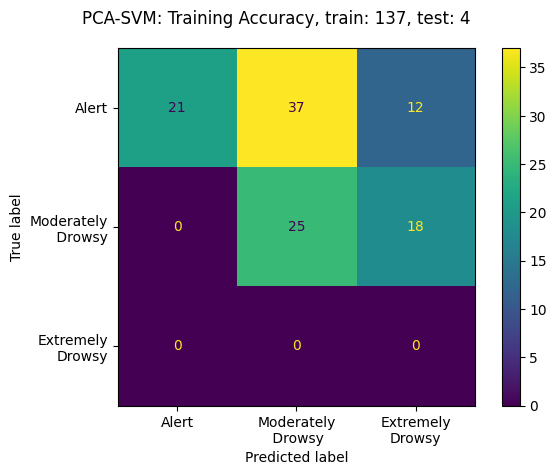

In [265]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_svm_pca, 
                      pca_standardscaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-SVM: Training Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [266]:
# PCA-SVM: Training Accuracy
classwise_accuracy(clf_svm_pca, pca_standardscaled, y)

Accuracy of Alert: 30.0000%
Accuracy of Moderately Drowsy: 58.1395%
Accuracy of Extremely Drowsy: nan%
----------------------------------------
Micro-average F1: 40.7080%
Weighted-average F1: 46.7114%
Macro-average F1: 31.2576%


C:\Users\Natchira\AppData\Local\Temp\ipykernel_23144\3378109123.py:9: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


{'class_accuracies': array([0.3       , 0.58139535,        nan]),
 'micro_f1': 0.40707964601769914,
 'weighted_f1': 0.46711400693701577,
 'macro_f1': 0.3125763125763126}

In [267]:
accuracy_newcase = accuracy_record(accuracy_newcase, clf_svm_pca, subject_train, subject_test, EEG_channel_train, 'pca', pca_standardscaled, y)
display(accuracy_newcase)

Accuracy of Alert: 30.0000%
Accuracy of Moderately Drowsy: 58.1395%
Accuracy of Extremely Drowsy: nan%
----------------------------------------
Micro-average F1: 40.7080%
Weighted-average F1: 46.7114%
Macro-average F1: 31.2576%


C:\Users\Natchira\AppData\Local\Temp\ipykernel_23144\3378109123.py:9: RuntimeWarning: invalid value encountered in divide
  class_accuracies = cm.diagonal() / cm.sum(axis=1)


,model,subject_train,subject_test,channel,input_features,num_features,class1_accuracy,class2_accuracy,class3_accuracy,micro_f1,weighted_f1,macro_f1
0,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,2,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.833333,0.586207,0.652174,0.720000,0.726424,0.690042
1,"SVC(C=10, class_weight='balanced', random_stat...",137,2,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.791667,0.344828,0.869565,0.680000,0.673821,0.640512
2,"SVC(C=10, class_weight='balanced', random_stat...",137,2,23,PCA,6,0.520833,0.517241,0.782609,0.580000,0.595674,0.580679
3,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,5,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.090909,1.000000,NaN,0.150943,0.164999,0.102694
4,"SVC(C=10, class_weight='balanced', random_stat...",137,5,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.141414,0.857143,NaN,0.188679,0.240229,0.127040
5,"SVC(C=10, class_weight='balanced', random_stat...",137,5,23,PCA,6,0.101010,0.714286,NaN,0.141509,0.178108,0.095176
6,"SVC(C=10, class_weight='balanced', gamma=0.1, ...",137,4,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.214286,0.813953,NaN,0.442478,0.433452,0.305819
7,"SVC(C=10, class_weight='balanced', random_stat...",137,4,23,"Epoch_minute, Initial_KSS, DeltaRelative_2, Th...",17,0.257143,0.674419,NaN,0.415929,0.457778,0.315376
8,"SVC(C=10, class_weight='balanced', random_stat...",137,4,23,PCA,6,0.300000,0.581395,NaN,0.407080,0.467114,0.312576


In [268]:
# Result Summary: SVM-PCA (training)
summary = result_summary(clf_svm_pca, X, pca_standardscaled, y)
display(summary)

,Original Index,Original Label,Predicted Label,True/False
0,0,1.0,1.0,True
1,1,1.0,1.0,True
2,2,1.0,1.0,True
3,3,1.0,1.0,True
4,4,1.0,1.0,True
...,...,...,...,...
114,114,2.0,2.0,True
115,115,2.0,2.0,True
116,116,2.0,2.0,True
117,117,2.0,3.0,False


##### **2. KNN**

In [82]:
clf_knn = callmodel(models, 'knn', 'cv', int(subject_train))

KeyError: 'clf_knn_cv_sub137'

In [83]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn, 
                      X_scaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized KNN: Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

NameError: name 'clf_knn' is not defined

In [343]:
print("Optimized KNN: Accuracy"
    + ", train: " + subject_train
    + ", test: " + subject_test)
print("-" * 40)
# Training Accuracy
classwise_accuracy(clf_knn, X_scaled, y)

Optimized KNN: Accuracy, train: 1234, test: 7
----------------------------------------
Accuracy of Alert: 86.1111%
Accuracy of Moderately Drowsy: 43.2432%
Accuracy of Extremely Drowsy: 55.5556%
----------------------------------------
Micro-average F1: 57.1429%
Weighted-average F1: 57.9756%
Macro-average F1: 51.4803%


In [344]:
summary = result_summary(clf_svm, X, X_scaled, y)

In [345]:
clf_knn_pca = callmodel(models, 'knn', 'pca', int(subject_train))

In [346]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject_train}_pca_transformer.pkl', "rb") as f:
    pca_transformer = pickle.load(f)

In [347]:
X_pca = pca_transformer.transform(X_scaled)

In [348]:
pc1_coords = X_pca[:, 0]
pc2_coords = X_pca[:, 1]
pc3_coords = X_pca[:, 2]
pc4_coords = X_pca[:, 3]
pc5_coords = X_pca[:, 4]
pc6_coords = X_pca[:, 5]

pca_scaled = scale(np.column_stack((pc1_coords, 
                                          pc2_coords, 
                                          pc3_coords, 
                                          pc4_coords, 
                                          pc5_coords, 
                                          pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

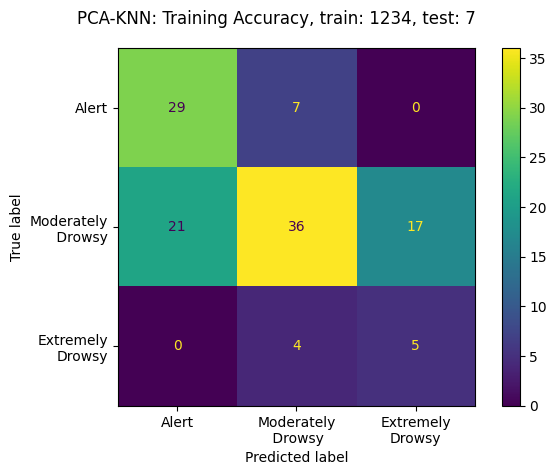

In [349]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_knn_pca, 
                      pca_scaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-KNN: Training Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [350]:
print("KNN-PCA: Accuracy"
    + ", train: " + subject_train
    + ", test: " + subject_test)
print("-" * 40)

# KNN-PCA: Training Accuracy
classwise_accuracy(clf_knn_pca, pca_scaled, y)

KNN-PCA: Accuracy, train: 1234, test: 7
----------------------------------------
Accuracy of Alert: 80.5556%
Accuracy of Moderately Drowsy: 48.6486%
Accuracy of Extremely Drowsy: 55.5556%
----------------------------------------
Micro-average F1: 58.8235%
Weighted-average F1: 59.8448%
Macro-average F1: 53.0680%


In [351]:
# Result Summary: SVM-PCA (training)
summary = result_summary(clf_knn_pca, X, pca_scaled, y)
display(summary)

,Original Index,Original Label,Predicted Label,True/False
0,0,1,1.0,True
1,1,1,1.0,True
2,2,1,1.0,True
3,3,1,1.0,True
4,4,1,1.0,True
...,...,...,...,...
114,114,2,2.0,True
115,115,2,3.0,False
116,116,2,3.0,False
117,117,2,2.0,True


##### **3. DT**

In [352]:
clf_dt = callmodel(models, 'dt', 'cv', int(subject_train))

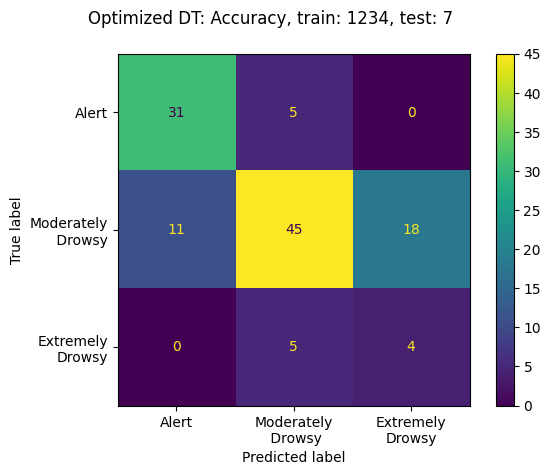

In [353]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt, 
                      X_scaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized DT: Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [354]:
print("Optimized DT: Accuracy"
    + ", train: " + subject_train
    + ", test: " + subject_test)
print("-" * 40)
# Training Accuracy
classwise_accuracy(clf_dt, X_scaled, y)

Optimized DT: Accuracy, train: 1234, test: 7
----------------------------------------
Accuracy of Alert: 86.1111%
Accuracy of Moderately Drowsy: 60.8108%
Accuracy of Extremely Drowsy: 44.4444%
----------------------------------------
Micro-average F1: 67.2269%
Weighted-average F1: 69.3831%
Macro-average F1: 58.3537%


In [355]:
summary = result_summary(clf_dt, X, X_scaled, y)

In [356]:
clf_dt_pca = callmodel(models, 'dt', 'pca', int(subject_train))

In [357]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject_train}_pca_transformer.pkl', "rb") as f:
    pca_transformer = pickle.load(f)

In [358]:
X_pca = pca_transformer.transform(X_scaled)

In [359]:
pc1_coords = X_pca[:, 0]
pc2_coords = X_pca[:, 1]
pc3_coords = X_pca[:, 2]
pc4_coords = X_pca[:, 3]
pc5_coords = X_pca[:, 4]
pc6_coords = X_pca[:, 5]

pca_scaled = scale(np.column_stack((pc1_coords, 
                                          pc2_coords, 
                                          pc3_coords, 
                                          pc4_coords, 
                                          pc5_coords, 
                                          pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

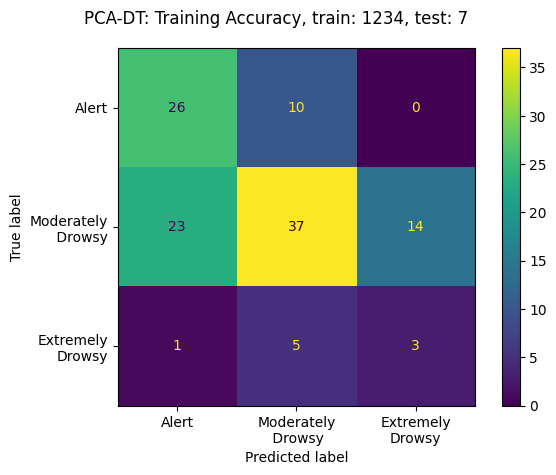

In [360]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_dt_pca, 
                      pca_scaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-DT: Training Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [361]:
print("DT-PCA: Accuracy"
    + ", train: " + subject_train
    + ", test: " + subject_test)
print("-" * 40)

# KNN-PCA: Training Accuracy
classwise_accuracy(clf_dt_pca, pca_scaled, y)

DT-PCA: Accuracy, train: 1234, test: 7
----------------------------------------
Accuracy of Alert: 72.2222%
Accuracy of Moderately Drowsy: 50.0000%
Accuracy of Extremely Drowsy: 33.3333%
----------------------------------------
Micro-average F1: 55.4622%
Weighted-average F1: 56.5586%
Macro-average F1: 47.4241%


In [362]:
# Result Summary: SVM-PCA (training)
summary = result_summary(clf_dt_pca, X, pca_scaled, y)
display(summary)

,Original Index,Original Label,Predicted Label,True/False
0,0,1,1.0,True
1,1,1,1.0,True
2,2,1,1.0,True
3,3,1,1.0,True
4,4,1,1.0,True
...,...,...,...,...
114,114,2,2.0,True
115,115,2,3.0,False
116,116,2,2.0,True
117,117,2,2.0,True


##### **4. RF**

In [363]:
clf_rf = callmodel(models, 'rf', 'cv', int(subject_train))

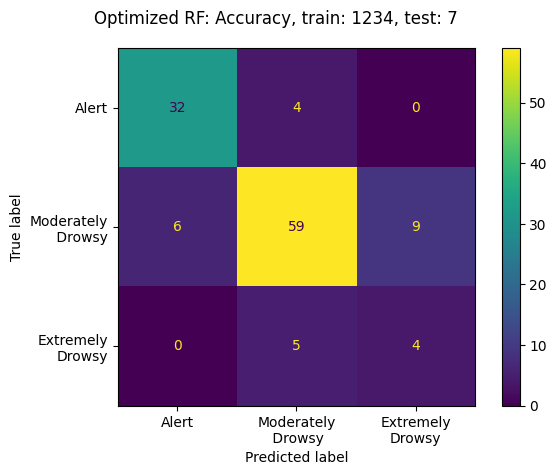

In [364]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf, 
                      X_scaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("Optimized RF: Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [365]:
print("Optimized RF: Accuracy"
    + ", train: " + subject_train
    + ", test: " + subject_test)
print("-" * 40)
# Training Accuracy
classwise_accuracy(clf_rf, X_scaled, y)

Optimized RF: Accuracy, train: 1234, test: 7
----------------------------------------
Accuracy of Alert: 88.8889%
Accuracy of Moderately Drowsy: 79.7297%
Accuracy of Extremely Drowsy: 44.4444%
----------------------------------------
Micro-average F1: 79.8319%
Weighted-average F1: 80.5889%
Macro-average F1: 68.6496%


In [366]:
summary = result_summary(clf_rf, X, X_scaled, y)

In [367]:
clf_rf_pca = callmodel(models, 'rf', 'pca', int(subject_train))

In [368]:
with open(f'C:/Users/Natchira/Documents/M.Eng Thesis/Model/subject{subject_train}_pca_transformer.pkl', "rb") as f:
    pca_transformer = pickle.load(f)

In [369]:
X_pca = pca_transformer.transform(X_scaled)

In [370]:
pc1_coords = X_pca[:, 0]
pc2_coords = X_pca[:, 1]
pc3_coords = X_pca[:, 2]
pc4_coords = X_pca[:, 3]
pc5_coords = X_pca[:, 4]
pc6_coords = X_pca[:, 5]

pca_scaled = scale(np.column_stack((pc1_coords, 
                                          pc2_coords, 
                                          pc3_coords, 
                                          pc4_coords, 
                                          pc5_coords, 
                                          pc6_coords, 
                                          # train_pc7_coords,
                                        #   train_pc8_coords
                                          )))

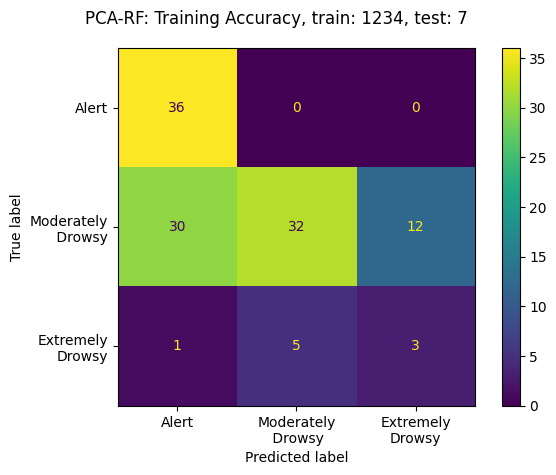

In [371]:
# Optimized SVM: Training Accuracy (Confusion Matrix)

ConfusionMatrix_Training = ConfusionMatrixDisplay.from_estimator(clf_rf_pca, 
                      pca_scaled, 
                      y,  
                      display_labels=['Alert','Moderately\n Drowsy', 'Extremely\nDrowsy'])

ConfusionMatrix_Training.figure_.suptitle("PCA-RF: Training Accuracy"
                                          + ", train: " + subject_train
                                          + ", test: " + subject_test)
plt.tight_layout()
plt.show()

In [372]:
print("RF-PCA: Accuracy"
    + ", train: " + subject_train
    + ", test: " + subject_test)
print("-" * 40)

# KNN-PCA: Training Accuracy
classwise_accuracy(clf_rf_pca, pca_scaled, y)

RF-PCA: Accuracy, train: 1234, test: 7
----------------------------------------
Accuracy of Alert: 100.0000%
Accuracy of Moderately Drowsy: 43.2432%
Accuracy of Extremely Drowsy: 33.3333%
----------------------------------------
Micro-average F1: 59.6639%
Weighted-average F1: 58.8922%
Macro-average F1: 50.8535%


In [373]:
# Result Summary: SVM-PCA (training)
summary = result_summary(clf_rf_pca, X, pca_scaled, y)
display(summary)

,Original Index,Original Label,Predicted Label,True/False
0,0,1,1.0,True
1,1,1,1.0,True
2,2,1,1.0,True
3,3,1,1.0,True
4,4,1,1.0,True
...,...,...,...,...
114,114,2,2.0,True
115,115,2,2.0,True
116,116,2,2.0,True
117,117,2,2.0,True
